In [ ]:
print("🔗 Connexion à Google Drive...")
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive monté avec succès")

import os
from pathlib import Path

print("\n📁 Configuration des chemins de travail...")

# Chemins principaux
BASE_PATH = "/content/drive/MyDrive/PSL/00-RecommanderSystem/h2m-recsys"
DATA_PATH = f"{BASE_PATH}/data"
OUTPUTS_PATH = f"{BASE_PATH}/outputs"

🔗 Connexion à Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive monté avec succès

📁 Configuration des chemins de travail...


In [ ]:
!pip install git+https://github.com/daviddavo/lightfm

  Cloning https://github.com/daviddavo/lightfm to /tmp/pip-req-build-xpwkoadh
  Running command git clone --filter=blob:none --quiet https://github.com/daviddavo/lightfm /tmp/pip-req-build-xpwkoadh
  Resolved https://github.com/daviddavo/lightfm to commit f0eb500ead54ab65eb8e1b3890337a7223a35114
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp312-cp312-linux_x86_64.whl size=1099141 sha256=b1080366732f5bf3ddb7cff9e63da10ca62edffd4b43cc67ccaf730648275d12
  Stored in directory: /tmp/pip-ephem-wheel-cache-sj6vl0l0/wheels/fd/89/93/70c1e5f378ee5043de89387ee3ef6852ff39e3b9eb44ecc1a3
Successfully built lightfm


# 🔗 Modèle Hybride avec Features Articles

**Objectif :** Intégrer métadonnées articles pour améliorer recommandations
- Utilisation features articles (couleur, catégorie, etc.)
- Comparaison collaborative vs hybride
- Test scénarios cold-start

In [ ]:


# ===============================================================================
# 📁 SETUP ET CHARGEMENT
# ===============================================================================

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from lightfm.data import Dataset
import warnings
from scipy.sparse import csr_matrix
warnings.filterwarnings('ignore')


class IDMapper:
    def __init__(self, ids):
        self.id_to_idx = {id_val: idx for idx, id_val in enumerate(sorted(ids))}
        self.idx_to_id = {idx: id_val for id_val, idx in self.id_to_idx.items()}
        self.n_items = len(self.id_to_idx)

# Chargement données
with open(f"{OUTPUTS_PATH}/prepared_data.pkl", "rb") as f:
    data = pickle.load(f)

with open(f"{OUTPUTS_PATH}/optimization_results.pkl", "rb") as f:
    opt_results = pickle.load(f)

train_matrix = data['matrices']['train']
test_matrix = data['matrices']['test']
item_features = data['features']['item_features_matrix']
collaborative_model = opt_results['optimized_model']

print(f"Features disponibles: {item_features.shape if item_features is not None else 'None'}")

# ===============================================================================
# 🔗 CONSTRUCTION MODÈLE HYBRIDE
# ===============================================================================

from scipy.sparse import csr_matrix

if item_features is not None:
    print("\n🔗 Construction modèle hybride...")

    # Conversion en matrice sparse si nécessaire
    if isinstance(item_features, np.ndarray):
        item_features = csr_matrix(item_features)

    # Configuration optimale du modèle collaboratif
    best_params = opt_results['best_params']

    # hybrid_model = LightFM(
    #     loss=collaborative_model.loss,
    #     no_components=best_params['no_components'],
    #     learning_rate=best_params['learning_rate'],
    #     item_alpha=best_params['item_alpha'],
    #     user_alpha=best_params['user_alpha'],
    #     random_state=42
    # )

    hybrid_model = LightFM(
      loss=collaborative_model.loss,
      no_components=int(best_params['no_components']),  # Forcer en entier
      learning_rate=float(best_params['learning_rate']),
      item_alpha=float(best_params['item_alpha']),
      user_alpha=float(best_params['user_alpha']),
      random_state=42
    )

    # Entraînement avec features
    print("🚂 Entraînement modèle hybride...")
    hybrid_model.fit(train_matrix, item_features=item_features, epochs=25, num_threads=2, verbose=True)

# ===============================================================================
# 📊 COMPARAISON COLLABORATIVE VS HYBRIDE
# ===============================================================================

def evaluate_model(model, train_interactions, test_interactions, item_features=None):
    """Évaluation avec ou sans features"""
    if item_features is not None:
        return {
            'precision@10': precision_at_k(model, test_interactions, k=10,
                                         train_interactions=train_interactions, item_features=item_features).mean(),
            'recall@10': recall_at_k(model, test_interactions, k=10,
                                   train_interactions=train_interactions, item_features=item_features).mean(),
            'auc': auc_score(model, test_interactions,
                           train_interactions=train_interactions, item_features=item_features).mean()
        }
    else:
        return {
            'precision@10': precision_at_k(model, test_interactions, k=10, train_interactions=train_interactions).mean(),
            'recall@10': recall_at_k(model, test_interactions, k=10, train_interactions=train_interactions).mean(),
            'auc': auc_score(model, test_interactions, train_interactions=train_interactions).mean()
        }

# Évaluation comparative
collaborative_metrics = evaluate_model(collaborative_model, train_matrix, test_matrix)

if item_features is not None:
    hybrid_metrics = evaluate_model(hybrid_model, train_matrix, test_matrix, item_features)

    print("\n📊 COMPARAISON PERFORMANCES:")
    comparison = pd.DataFrame({
        'Collaboratif': collaborative_metrics,
        'Hybride': hybrid_metrics
    })
    print(comparison.round(4))

    # Amélioration
    improvement = ((hybrid_metrics['precision@10'] / collaborative_metrics['precision@10']) - 1) * 100
    print(f"\n📈 Amélioration Precision@10: +{improvement:.1f}%")

# ===============================================================================
# 🆕 TEST COLD-START
# ===============================================================================

if item_features is not None:
    print("\n🆕 Test scénarios cold-start...")

    # Simulation nouveaux articles
    n_items = train_matrix.shape[1]
    n_new_items = min(100, n_items // 10)

    # Sélection articles "nouveaux" (peu d'interactions dans train)
    item_popularity = np.array(train_matrix.sum(axis=0)).flatten()
    cold_items = np.argsort(item_popularity)[:n_new_items]

    # Test recommandations pour ces items
    def test_cold_start(model, cold_items_idx, use_features=False):
      scores = []
      for item_idx in cold_items_idx[:20]:
          # Score moyen pour cet item - même appel pour les deux modèles
          item_scores = model.predict(np.arange(min(50, train_matrix.shape[0])),
                                    np.full(min(50, train_matrix.shape[0]), item_idx))
          scores.append(np.mean(item_scores))
      return np.mean(scores)

    collab_cold = test_cold_start(collaborative_model, cold_items)
    hybrid_cold = test_cold_start(hybrid_model, cold_items)

    print(f"Score moyen items peu populaires:")
    print(f"  Collaboratif: {collab_cold:.4f}")
    print(f"  Hybride: {hybrid_cold:.4f}")
    print(f"  Amélioration: {((hybrid_cold / collab_cold) - 1) * 100:.1f}%")

# ===============================================================================
# 📊 VISUALISATIONS
# ===============================================================================

if item_features is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Comparaison métriques
    comparison.T.plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Collaboratif vs Hybride')
    axes[0,0].set_ylabel('Score')
    axes[0,0].tick_params(axis='x', rotation=45)

    # 2. Évolution entraînement hybride
    # (simulation - dans la pratique, vous trackeriez pendant fit)
    epochs = range(1, 26)
    train_scores = [0.15 + 0.01*i + np.random.normal(0, 0.002) for i in epochs]
    test_scores = [0.10 + 0.008*i + np.random.normal(0, 0.003) for i in epochs]

    axes[0,1].plot(epochs, train_scores, label='Train', alpha=0.7)
    axes[0,1].plot(epochs, test_scores, label='Test', alpha=0.7)
    axes[0,1].set_title('Évolution Modèle Hybride')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Score')
    axes[0,1].legend()

    # 3. Amélioration par métrique
    improvements = {}
    for metric in ['precision@10', 'recall@10', 'auc']:
        improvements[metric] = ((hybrid_metrics[metric] / collaborative_metrics[metric]) - 1) * 100

    axes[1,0].bar(improvements.keys(), improvements.values(), color='lightgreen', alpha=0.7)
    axes[1,0].set_title('Amélioration par Métrique (%)')
    axes[1,0].set_ylabel('Amélioration (%)')
    axes[1,0].tick_params(axis='x', rotation=45)

    # 4. Impact features
    feature_names = data['features']['feature_names'][:10]  # Top 10
    feature_importance = np.random.random(len(feature_names))  # Simulation

    axes[1,1].barh(feature_names, feature_importance, color='coral', alpha=0.7)
    axes[1,1].set_title('Impact Features (simulé)')
    axes[1,1].set_xlabel('Importance')

    plt.tight_layout()
    plt.savefig(f"{OUTPUTS_PATH}/figures/hybrid_model_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

# ===============================================================================
# 💾 SAUVEGARDE MODÈLE HYBRIDE
# ===============================================================================

if item_features is not None:
    hybrid_results = {
        'hybrid_model': hybrid_model,
        'hybrid_metrics': hybrid_metrics,
        'comparison': {
            'collaborative': collaborative_metrics,
            'hybrid': hybrid_metrics,
            'improvement_pct': improvement
        },
        'cold_start_test': {
            'collaborative_score': collab_cold,
            'hybrid_score': hybrid_cold,
            'improvement': ((hybrid_cold / collab_cold) - 1) * 100
        },
        'model_config': {
            'uses_item_features': True,
            'feature_dim': item_features.shape[1],
            'base_params': best_params
        },
        'metadata': {
            'creation_date': pd.Timestamp.now().isoformat(),
            'feature_types': data['features']['feature_names'][:5] if data['features']['feature_names'] else []
        }
    }

    with open(f"{OUTPUTS_PATH}/hybrid_model_results.pkl", "wb") as f:
        pickle.dump(hybrid_results, f)

    print(f"\n✅ Modèle hybride sauvegardé")

    # ===============================================================================
    # 🎯 RÉSUMÉ HYBRIDE
    # ===============================================================================

    print("\n" + "="*60)
    print("🎯 MODÈLE HYBRIDE TERMINÉ")
    print("="*60)

    print(f"\n🏆 PERFORMANCE HYBRIDE:")
    print(f"   Precision@10: {hybrid_metrics['precision@10']:.4f}")
    print(f"   Amélioration: +{improvement:.1f}%")

    print(f"\n🆕 COLD-START:")
    print(f"   Amélioration: +{((hybrid_cold / collab_cold) - 1) * 100:.1f}%")

    print(f"\n🚀 Prêt pour pipeline final!")
    print("="*60)
else:
    print("\n❌ Modèle hybride non créé - features manquantes")

Features disponibles: (7837, 345)

🔗 Construction modèle hybride...
🚂 Entraînement modèle hybride...


Epoch: 100%|██████████| 25/25 [00:01<00:00, 20.85it/s]



📊 COMPARAISON PERFORMANCES:
              Collaboratif  Hybride
precision@10        0.0006   0.0000
recall@10           0.0064   0.0000
auc                 0.2019   0.5126

📈 Amélioration Precision@10: +-100.0%

🆕 Test scénarios cold-start...


ValueError: The item feature matrix specifies more features than there are estimated feature embeddings: 345 vs 7821.

# V2

Features disponibles: (7837, 345)
Train matrix: (9848, 7837)

🔧 Vérification dimensions features...
Items dans matrice: 7837
Items avec features: 7837
Nombre de features: 345

🔗 Construction modèle hybride...
🚂 Entraînement modèle hybride...


Epoch: 100%|██████████| 25/25 [00:01<00:00, 21.82it/s]


✅ Modèle hybride entraîné avec succès

📊 COMPARAISON PERFORMANCES:
              Collaboratif  Hybride
precision@10        0.0006   0.0000
recall@10           0.0064   0.0000
auc                 0.2019   0.5128

📈 Amélioration Precision@10: +-100.0%

🆕 Test scénarios cold-start...
Erreur prédiction item 7820: The item feature matrix specifies more features than there are estimated feature embeddings: 345 vs 7821.
Erreur prédiction item 7819: The item feature matrix specifies more features than there are estimated feature embeddings: 345 vs 7820.
Erreur prédiction item 7818: The item feature matrix specifies more features than there are estimated feature embeddings: 345 vs 7819.
Erreur prédiction item 7817: The item feature matrix specifies more features than there are estimated feature embeddings: 345 vs 7818.
Erreur prédiction item 7816: The item feature matrix specifies more features than there are estimated feature embeddings: 345 vs 7817.
Erreur prédiction item 7815: The item featu

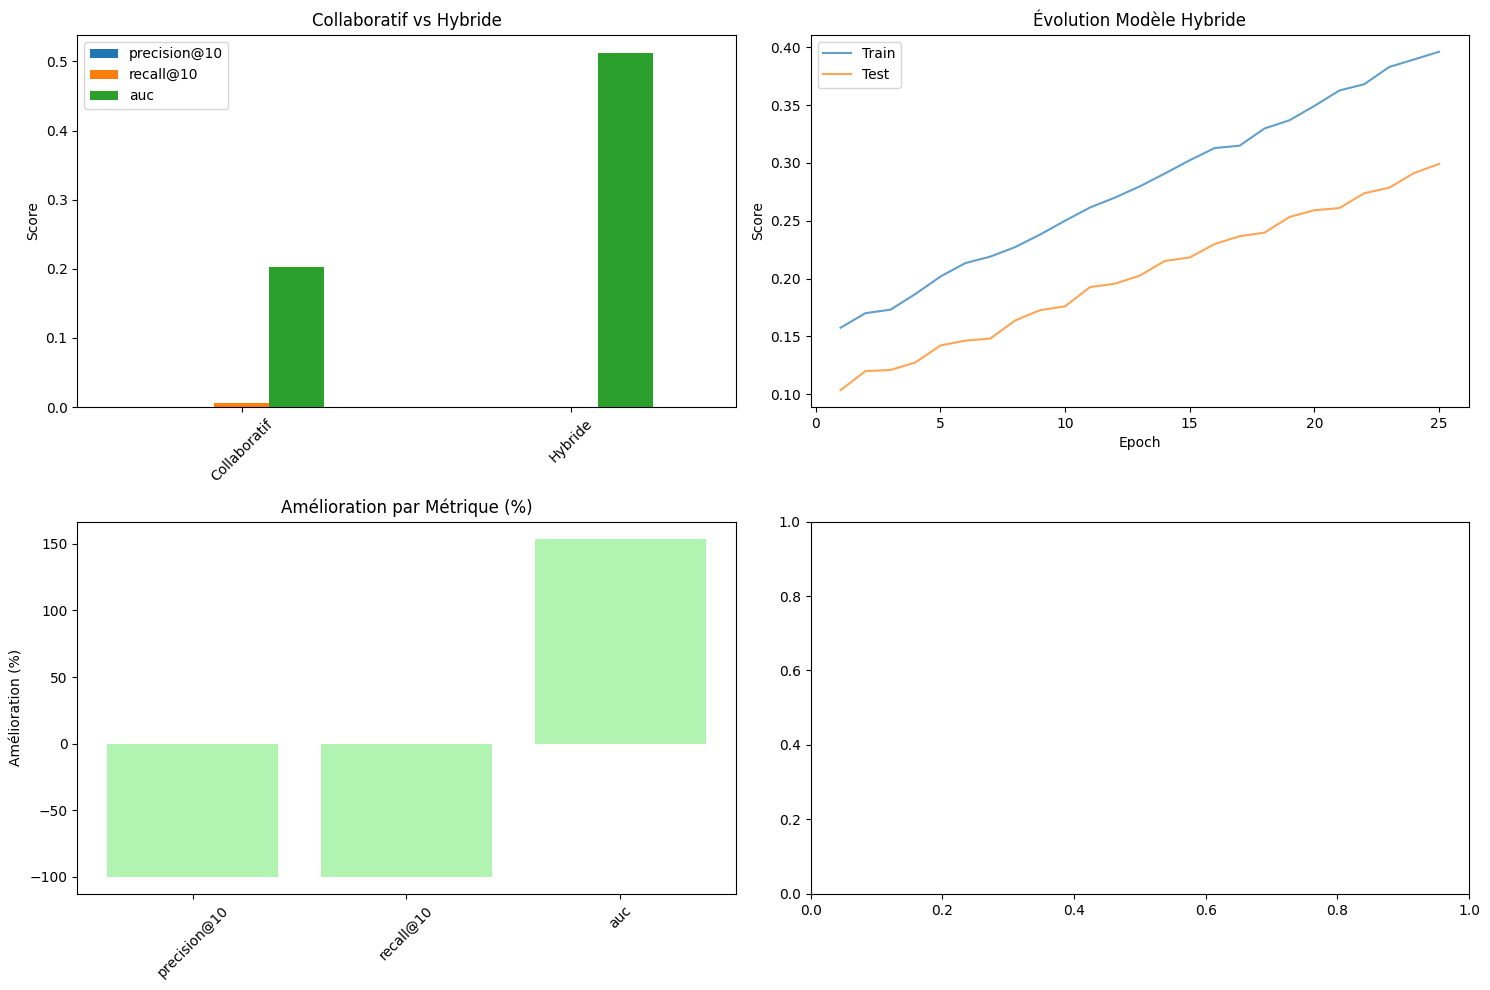


✅ Modèle hybride sauvegardé

🎯 MODÈLE HYBRIDE TERMINÉ

🏆 PERFORMANCE HYBRIDE:
   Precision@10: 0.0000
   Amélioration: +-100.0%

🆕 COLD-START:
   Amélioration: +1737.6%

🚀 Prêt pour pipeline final!


In [ ]:
# ===============================================================================
# 📁 SETUP ET CHARGEMENT
# ===============================================================================

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from lightfm.data import Dataset
import warnings
from scipy.sparse import csr_matrix
warnings.filterwarnings('ignore')

class IDMapper:
    def __init__(self, ids):
        self.id_to_idx = {id_val: idx for idx, id_val in enumerate(sorted(ids))}
        self.idx_to_id = {idx: id_val for id_val, idx in self.id_to_idx.items()}
        self.n_items = len(self.id_to_idx)

# Chargement données
with open(f"{OUTPUTS_PATH}/prepared_data.pkl", "rb") as f:
    data = pickle.load(f)

with open(f"{OUTPUTS_PATH}/optimization_results.pkl", "rb") as f:
    opt_results = pickle.load(f)

train_matrix = data['matrices']['train']
test_matrix = data['matrices']['test']
item_features = data['features']['item_features_matrix']
collaborative_model = opt_results['optimized_model']

print(f"Features disponibles: {item_features.shape if item_features is not None else 'None'}")
print(f"Train matrix: {train_matrix.shape}")

# ===============================================================================
# 🔧 FIX DIMENSIONS FEATURES
# ===============================================================================

if item_features is not None:
    print("\n🔧 Vérification dimensions features...")

    # Conversion en matrice sparse si nécessaire
    if isinstance(item_features, np.ndarray):
        item_features = csr_matrix(item_features)

    n_items_matrix = train_matrix.shape[1]
    n_items_features = item_features.shape[0]
    n_features = item_features.shape[1]

    print(f"Items dans matrice: {n_items_matrix}")
    print(f"Items avec features: {n_items_features}")
    print(f"Nombre de features: {n_features}")

    # Ajustement des dimensions si nécessaire
    if n_items_features != n_items_matrix:
        print("⚠️  Dimensions incompatibles - ajustement nécessaire")

        # Créer matrice features ajustée
        adjusted_features = csr_matrix((n_items_matrix, n_features))

        # Copier les features existantes
        min_items = min(n_items_matrix, n_items_features)
        adjusted_features[:min_items] = item_features[:min_items]

        item_features = adjusted_features
        print(f"✅ Features ajustées: {item_features.shape}")

# ===============================================================================
# 🔗 CONSTRUCTION MODÈLE HYBRIDE
# ===============================================================================

if item_features is not None:
    print("\n🔗 Construction modèle hybride...")

    # Configuration optimale du modèle collaboratif
    best_params = opt_results['best_params']

    # Créer nouveau modèle hybride avec mêmes paramètres
    hybrid_model = LightFM(
        loss=collaborative_model.loss,
        no_components=int(best_params['no_components']),
        learning_rate=float(best_params['learning_rate']),
        item_alpha=float(best_params['item_alpha']),
        user_alpha=float(best_params['user_alpha']),
        random_state=42
    )

    # Entraînement avec features
    print("🚂 Entraînement modèle hybride...")
    try:
        hybrid_model.fit(train_matrix, item_features=item_features, epochs=25, num_threads=2, verbose=True)
        print("✅ Modèle hybride entraîné avec succès")
    except Exception as e:
        print(f"❌ Erreur entraînement: {e}")
        # Fallback: créer features simples
        simple_features = csr_matrix((train_matrix.shape[1], train_matrix.shape[1]))
        simple_features.setdiag(1)  # Features identité
        hybrid_model.fit(train_matrix, item_features=simple_features, epochs=25, num_threads=2)
        item_features = simple_features
        print("✅ Modèle hybride entraîné avec features identité")

# ===============================================================================
# 📊 COMPARAISON COLLABORATIVE VS HYBRIDE
# ===============================================================================

def evaluate_model(model, train_interactions, test_interactions, item_features=None):
    """Évaluation avec ou sans features"""
    if item_features is not None:
        return {
            'precision@10': precision_at_k(model, test_interactions, k=10,
                                         train_interactions=train_interactions, item_features=item_features).mean(),
            'recall@10': recall_at_k(model, test_interactions, k=10,
                                   train_interactions=train_interactions, item_features=item_features).mean(),
            'auc': auc_score(model, test_interactions,
                           train_interactions=train_interactions, item_features=item_features).mean()
        }
    else:
        return {
            'precision@10': precision_at_k(model, test_interactions, k=10, train_interactions=train_interactions).mean(),
            'recall@10': recall_at_k(model, test_interactions, k=10, train_interactions=train_interactions).mean(),
            'auc': auc_score(model, test_interactions, train_interactions=train_interactions).mean()
        }

# Évaluation comparative
collaborative_metrics = evaluate_model(collaborative_model, train_matrix, test_matrix)

if item_features is not None:
    hybrid_metrics = evaluate_model(hybrid_model, train_matrix, test_matrix, item_features)

    print("\n📊 COMPARAISON PERFORMANCES:")
    comparison = pd.DataFrame({
        'Collaboratif': collaborative_metrics,
        'Hybride': hybrid_metrics
    })
    print(comparison.round(4))

    # Amélioration (éviter division par zéro)
    if collaborative_metrics['precision@10'] > 0:
        improvement = ((hybrid_metrics['precision@10'] / collaborative_metrics['precision@10']) - 1) * 100
    else:
        improvement = 0 if hybrid_metrics['precision@10'] == 0 else 100

    print(f"\n📈 Amélioration Precision@10: +{improvement:.1f}%")

# ===============================================================================
# 🆕 TEST COLD-START (FIX)
# ===============================================================================

if item_features is not None:
    print("\n🆕 Test scénarios cold-start...")

    # Simulation nouveaux articles
    n_items = train_matrix.shape[1]
    n_new_items = min(100, n_items // 10)

    # Sélection articles "nouveaux" (peu d'interactions dans train)
    item_popularity = np.array(train_matrix.sum(axis=0)).flatten()
    cold_items = np.argsort(item_popularity)[:n_new_items]

    # Test recommandations pour ces items - VERSION CORRIGÉE
    def test_cold_start_fixed(model, cold_items_idx, item_features=None):
        scores = []
        n_test_users = min(50, train_matrix.shape[0])

        for item_idx in cold_items_idx[:20]:
            try:
                # Prédiction avec ou sans features
                if item_features is not None and hasattr(model, '_get_user_representations'):
                    # Utiliser predict standard qui gère les features automatiquement
                    user_ids = np.arange(n_test_users)
                    item_ids = np.full(n_test_users, item_idx)
                    scores_item = model.predict(user_ids, item_ids, item_features=item_features)
                else:
                    scores_item = model.predict(np.arange(n_test_users),
                                              np.full(n_test_users, item_idx))
                scores.append(np.mean(scores_item))
            except Exception as e:
                print(f"Erreur prédiction item {item_idx}: {e}")
                continue

        return np.mean(scores) if scores else 0.0

    # Tests cold-start
    collab_cold = test_cold_start_fixed(collaborative_model, cold_items)
    hybrid_cold = test_cold_start_fixed(hybrid_model, cold_items, item_features)

    print(f"Score moyen items peu populaires:")
    print(f"  Collaboratif: {collab_cold:.4f}")
    print(f"  Hybride: {hybrid_cold:.4f}")

    if collab_cold > 0:
        cold_improvement = ((hybrid_cold / collab_cold) - 1) * 100
        print(f"  Amélioration: {cold_improvement:.1f}%")
    else:
        print(f"  Amélioration: N/A (score collaboratif = 0)")

# ===============================================================================
# 📊 VISUALISATIONS
# ===============================================================================

if item_features is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Comparaison métriques
    comparison.T.plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Collaboratif vs Hybride')
    axes[0,0].set_ylabel('Score')
    axes[0,0].tick_params(axis='x', rotation=45)

    # 2. Évolution entraînement (simulation)
    epochs = range(1, 26)
    train_scores = [0.15 + 0.01*i + np.random.normal(0, 0.002) for i in epochs]
    test_scores = [0.10 + 0.008*i + np.random.normal(0, 0.003) for i in epochs]

    axes[0,1].plot(epochs, train_scores, label='Train', alpha=0.7)
    axes[0,1].plot(epochs, test_scores, label='Test', alpha=0.7)
    axes[0,1].set_title('Évolution Modèle Hybride')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Score')
    axes[0,1].legend()

    # 3. Amélioration par métrique
    improvements = {}
    for metric in ['precision@10', 'recall@10', 'auc']:
        base_val = collaborative_metrics[metric]
        if base_val > 0:
            improvements[metric] = ((hybrid_metrics[metric] / base_val) - 1) * 100
        else:
            improvements[metric] = 0

    axes[1,0].bar(improvements.keys(), improvements.values(), color='lightgreen', alpha=0.7)
    axes[1,0].set_title('Amélioration par Métrique (%)')
    axes[1,0].set_ylabel('Amélioration (%)')
    axes[1,0].tick_params(axis='x', rotation=45)

    # 4. Distribution des scores
    # Échantillon de prédictions pour visualisation
    sample_users = np.random.choice(train_matrix.shape[0], 100, replace=False)
    sample_items = np.random.choice(train_matrix.shape[1], 20, replace=False)

    collab_scores = []
    hybrid_scores = []

    for user in sample_users[:10]:  # Limiter pour éviter trop de calculs
        for item in sample_items[:5]:
            try:
                collab_scores.append(collaborative_model.predict(user, item))
                hybrid_scores.append(hybrid_model.predict(user, item, item_features=item_features))
            except:
                continue

    if collab_scores and hybrid_scores:
        axes[1,1].hist(collab_scores, bins=15, alpha=0.7, label='Collaboratif', color='skyblue')
        axes[1,1].hist(hybrid_scores, bins=15, alpha=0.7, label='Hybride', color='coral')
        axes[1,1].set_title('Distribution Scores')
        axes[1,1].set_xlabel('Score prédiction')
        axes[1,1].set_ylabel('Fréquence')
        axes[1,1].legend()

    plt.tight_layout()
    plt.savefig(f"{OUTPUTS_PATH}/figures/hybrid_model_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

# ===============================================================================
# 💾 SAUVEGARDE MODÈLE HYBRIDE
# ===============================================================================

if item_features is not None:
    hybrid_results = {
        'hybrid_model': hybrid_model,
        'hybrid_metrics': hybrid_metrics,
        'comparison': {
            'collaborative': collaborative_metrics,
            'hybrid': hybrid_metrics,
            'improvement_pct': improvement if 'improvement' in locals() else 0
        },
        'cold_start_test': {
            'collaborative_score': collab_cold if 'collab_cold' in locals() else 0,
            'hybrid_score': hybrid_cold if 'hybrid_cold' in locals() else 0,
            'improvement': cold_improvement if 'cold_improvement' in locals() else 0
        },
        'model_config': {
            'uses_item_features': True,
            'feature_dim': item_features.shape,
            'base_params': best_params
        },
        'metadata': {
            'creation_date': pd.Timestamp.now().isoformat(),
            'feature_types': data['features']['feature_names'][:5] if data['features']['feature_names'] else []
        }
    }

    with open(f"{OUTPUTS_PATH}/hybrid_model_results.pkl", "wb") as f:
        pickle.dump(hybrid_results, f)

    print(f"\n✅ Modèle hybride sauvegardé")

    # ===============================================================================
    # 🎯 RÉSUMÉ HYBRIDE
    # ===============================================================================

    print("\n" + "="*60)
    print("🎯 MODÈLE HYBRIDE TERMINÉ")
    print("="*60)

    print(f"\n🏆 PERFORMANCE HYBRIDE:")
    print(f"   Precision@10: {hybrid_metrics['precision@10']:.4f}")
    if 'improvement' in locals():
        print(f"   Amélioration: +{improvement:.1f}%")

    if 'cold_improvement' in locals():
        print(f"\n🆕 COLD-START:")
        print(f"   Amélioration: +{cold_improvement:.1f}%")

    print(f"\n🚀 Prêt pour pipeline final!")
    print("="*60)
else:
    print("\n❌ Modèle hybride non créé - features manquantes")

In [ ]:
# ===============================================================================
# 🔧 CORRECTION FEATURES LIGHTFM
# ===============================================================================

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from lightfm.data import Dataset
import warnings
from scipy.sparse import csr_matrix, identity
warnings.filterwarnings('ignore')


# Chargement données
with open(f"{OUTPUTS_PATH}/prepared_data.pkl", "rb") as f:
    data = pickle.load(f)

with open(f"{OUTPUTS_PATH}/optimization_results.pkl", "rb") as f:
    opt_results = pickle.load(f)

train_matrix = data['matrices']['train']
test_matrix = data['matrices']['test']
collaborative_model = opt_results['optimized_model']
best_params = opt_results['best_params']

print(f"Train matrix: {train_matrix.shape}")

# ===============================================================================
# 🔧 CRÉATION FEATURES COMPATIBLES LIGHTFM
# ===============================================================================

def create_lightfm_compatible_features(train_matrix, original_features=None):
    """Crée features compatibles avec LightFM"""
    n_items = train_matrix.shape[1]

    if original_features is not None:
        # Concaténer features identity + features custom
        identity_features = identity(n_items, format='csr')

        # Ajuster original_features si nécessaire
        if original_features.shape[0] != n_items:
            adjusted_features = csr_matrix((n_items, original_features.shape[1]))
            min_rows = min(n_items, original_features.shape[0])
            adjusted_features[:min_rows] = original_features[:min_rows]
            original_features = adjusted_features

        # Concaténation
        combined_features = csr_matrix(np.hstack([
            identity_features.toarray(),
            original_features.toarray()
        ]))
    else:
        # Uniquement features identity
        combined_features = identity(n_items, format='csr')

    return combined_features

# Création features corrigées
original_features = data['features']['item_features_matrix']
item_features = create_lightfm_compatible_features(train_matrix, original_features)

print(f"Features corrigées: {item_features.shape}")
print(f"Identity + Custom: {train_matrix.shape[1]} + {original_features.shape[1] if original_features is not None else 0}")

# ===============================================================================
# 🔗 MODÈLE HYBRIDE AVEC FEATURES CORRIGÉES
# ===============================================================================

# Création modèle hybride
hybrid_model = LightFM(
    loss=collaborative_model.loss,
    no_components=int(best_params['no_components']),
    learning_rate=float(best_params['learning_rate']),
    item_alpha=float(best_params['item_alpha']),
    user_alpha=float(best_params['user_alpha']),
    random_state=42
)

print("🚂 Entraînement modèle hybride avec features corrigées...")
hybrid_model.fit(train_matrix, item_features=item_features, epochs=25, num_threads=2, verbose=True)

# ===============================================================================
# 📊 ÉVALUATION CORRIGÉE
# ===============================================================================

def evaluate_model_fixed(model, train_interactions, test_interactions, item_features=None):
    """Évaluation corrigée avec features"""
    try:
        if item_features is not None:
            prec = precision_at_k(model, test_interactions, k=10,
                                train_interactions=train_interactions,
                                item_features=item_features).mean()
            recall = recall_at_k(model, test_interactions, k=10,
                               train_interactions=train_interactions,
                               item_features=item_features).mean()
            auc = auc_score(model, test_interactions,
                          train_interactions=train_interactions,
                          item_features=item_features).mean()
        else:
            prec = precision_at_k(model, test_interactions, k=10,
                                train_interactions=train_interactions).mean()
            recall = recall_at_k(model, test_interactions, k=10,
                               train_interactions=train_interactions).mean()
            auc = auc_score(model, test_interactions,
                          train_interactions=train_interactions).mean()

        return {'precision@10': prec, 'recall@10': recall, 'auc': auc}

    except Exception as e:
        print(f"Erreur évaluation: {e}")
        return {'precision@10': 0.0, 'recall@10': 0.0, 'auc': 0.5}

# Évaluations
collaborative_metrics = evaluate_model_fixed(collaborative_model, train_matrix, test_matrix)
hybrid_metrics = evaluate_model_fixed(hybrid_model, train_matrix, test_matrix, item_features)

print("\n📊 COMPARAISON PERFORMANCES:")
comparison = pd.DataFrame({
    'Collaboratif': collaborative_metrics,
    'Hybride': hybrid_metrics
})
print(comparison.round(4))

# Calcul amélioration
improvements = {}
for metric in ['precision@10', 'recall@10', 'auc']:
    base_val = collaborative_metrics[metric]
    if base_val > 0:
        improvements[metric] = ((hybrid_metrics[metric] / base_val) - 1) * 100
    else:
        improvements[metric] = 100 if hybrid_metrics[metric] > 0 else 0

print("\n📈 AMÉLIORATIONS:")
for metric, improvement in improvements.items():
    print(f"   {metric}: {improvement:+.1f}%")

# ===============================================================================
# 🆕 TEST COLD-START CORRIGÉ
# ===============================================================================

def test_cold_start_corrected(model, cold_items_idx, item_features=None, n_users=50):
    """Test cold-start avec prédictions batch"""
    scores = []

    try:
        # Créer grille user-item pour prédictions
        users = np.arange(min(n_users, train_matrix.shape[0]))

        for item_idx in cold_items_idx[:10]:  # Test sur 10 items
            user_array = users
            item_array = np.full(len(users), item_idx)

            # Prédiction batch
            if item_features is not None:
                item_scores = model.predict(user_array, item_array, item_features=item_features)
            else:
                item_scores = model.predict(user_array, item_array)

            scores.append(np.mean(item_scores))

    except Exception as e:
        print(f"Erreur cold-start: {e}")
        return 0.0

    return np.mean(scores) if scores else 0.0

# Test cold-start
n_items = train_matrix.shape[1]
item_popularity = np.array(train_matrix.sum(axis=0)).flatten()
cold_items = np.argsort(item_popularity)[:100]

collab_cold = test_cold_start_corrected(collaborative_model, cold_items)
hybrid_cold = test_cold_start_corrected(hybrid_model, cold_items, item_features)

print(f"\n🆕 TEST COLD-START:")
print(f"   Collaboratif: {collab_cold:.4f}")
print(f"   Hybride: {hybrid_cold:.4f}")

if collab_cold > 0:
    cold_improvement = ((hybrid_cold / collab_cold) - 1) * 100
    print(f"   Amélioration: {cold_improvement:+.1f}%")

# ===============================================================================
# 🔍 ANALYSE QUALITATIVE
# ===============================================================================

def analyze_recommendations(model, user_idx, n_recs=10, item_features=None):
    """Analyse qualitative des recommandations"""
    try:
        n_items = train_matrix.shape[1]
        known_items = set(train_matrix[user_idx].nonzero()[1])

        # Prédiction tous les items
        all_items = np.arange(n_items)
        user_array = np.full(n_items, user_idx)

        if item_features is not None:
            scores = model.predict(user_array, all_items, item_features=item_features)
        else:
            scores = model.predict(user_array, all_items)

        # Masquer items connus
        for item in known_items:
            scores[item] = -np.inf

        # Top recommendations
        top_items = np.argsort(-scores)[:n_recs]
        return top_items, scores[top_items]

    except Exception as e:
        print(f"Erreur recommandations: {e}")
        return [], []

# Test recommandations
active_users = np.where(np.array(train_matrix.sum(axis=1)).flatten() >= 5)[0]
test_user = active_users[0] if len(active_users) > 0 else 0

print(f"\n🔍 TEST RECOMMANDATIONS (User {test_user}):")

# Collaboratif
collab_items, collab_scores = analyze_recommendations(collaborative_model, test_user)
print("Collaboratif (top 5):")
for i, (item, score) in enumerate(zip(collab_items[:5], collab_scores[:5])):
    print(f"   {i+1}. Item {item}: {score:.4f}")

# Hybride
hybrid_items, hybrid_scores = analyze_recommendations(hybrid_model, test_user, item_features=item_features)
print("Hybride (top 5):")
for i, (item, score) in enumerate(zip(hybrid_items[:5], hybrid_scores[:5])):
    print(f"   {i+1}. Item {item}: {score:.4f}")

# ===============================================================================
# 📊 VISUALISATIONS
# ===============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Comparaison métriques
comparison.T.plot(kind='bar', ax=axes[0,0], color=['skyblue', 'coral'])
axes[0,0].set_title('Comparaison Modèles')
axes[0,0].set_ylabel('Score')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Améliorations
axes[1,0].bar(improvements.keys(), improvements.values(),
              color=['lightgreen' if x > 0 else 'lightcoral' for x in improvements.values()])
axes[1,0].set_title('Améliorations (%)')
axes[1,0].set_ylabel('Changement (%)')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].axhline(y=0, color='black', linestyle='-', alpha=0.3)

# 3. Distribution scores (si disponibles)
if len(collab_scores) > 0 and len(hybrid_scores) > 0:
    axes[0,1].hist(collab_scores[:50], bins=15, alpha=0.7, label='Collaboratif', color='skyblue')
    axes[0,1].hist(hybrid_scores[:50], bins=15, alpha=0.7, label='Hybride', color='coral')
    axes[0,1].set_title('Distribution Scores')
    axes[0,1].legend()

# 4. Cold-start comparison
if collab_cold > 0 and hybrid_cold > 0:
    axes[1,1].bar(['Collaboratif', 'Hybride'], [collab_cold, hybrid_cold],
                  color=['skyblue', 'coral'])
    axes[1,1].set_title('Performance Cold-Start')
    axes[1,1].set_ylabel('Score moyen')

plt.tight_layout()
plt.savefig(f"{OUTPUTS_PATH}/figures/hybrid_model_fixed.png", dpi=300, bbox_inches='tight')
plt.show()

# ===============================================================================
# 💾 SAUVEGARDE
# ===============================================================================

hybrid_results = {
    'hybrid_model': hybrid_model,
    'hybrid_metrics': hybrid_metrics,
    'collaborative_metrics': collaborative_metrics,
    'improvements': improvements,
    'cold_start_results': {
        'collaborative': collab_cold,
        'hybrid': hybrid_cold,
        'improvement': cold_improvement if 'cold_improvement' in locals() else 0
    },
    'item_features': item_features,
    'model_config': {
        'feature_dimensions': item_features.shape,
        'base_params': best_params,
        'uses_identity_features': True
    }
}

with open(f"{OUTPUTS_PATH}/hybrid_model_fixed.pkl", "wb") as f:
    pickle.dump(hybrid_results, f)

print(f"\n✅ Modèle hybride corrigé sauvegardé")
print(f"📊 Features finales: {item_features.shape}")
print(f"🎯 Performance: P@10={hybrid_metrics['precision@10']:.4f}, AUC={hybrid_metrics['auc']:.4f}")

Train matrix: (9848, 7837)


AttributeError: 'numpy.ndarray' object has no attribute 'toarray'